In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from argparse import Namespace
import os
from pathlib import Path
from tqdm.notebook import trange, tqdm
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from score_sde.models.discriminator import Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp

In [3]:
def load_checkpoint(net, ckpt_path):
    ckpt = torch.load(ckpt_path)
    for key in list(ckpt.keys()):
        ckpt[key[7:]] = ckpt.pop(key)
    net.load_state_dict(ckpt)

device = "cuda:0"
#device = "cpu"
args = Namespace(seed=1024, resume=True, image_size=32, num_channels=3, centered=True, use_geometric=False, beta_min=0.1, beta_max=20.0, num_channels_dae=128, n_mlp=4, ch_mult=[1, 2, 2, 2], num_res_blocks=2, attn_resolutions=(16,), dropout=0.0, resamp_with_conv=True, conditional=True, fir=True, fir_kernel=[1, 3, 3, 1], skip_rescale=True, resblock_type='biggan', progressive='none', progressive_input='residual', progressive_combine='sum', embedding_type='positional', fourier_scale=16.0, not_use_tanh=False, exp='ddgan_stackmnist_exp1', dataset='stackmnist', nz=100, num_timesteps=4, z_emb_dim=256, t_emb_dim=256, batch_size=64, num_epoch=1800, ngf=64, lr_g=0.00016, lr_d=0.000125, beta1=0.5, beta2=0.9, no_lr_decay=False, use_ema=True, ema_decay=0.9999, r1_gamma=0.02, lazy_reg=15, save_content=True, save_content_every=100, save_ckpt_every=100, num_proc_node=1, num_process_per_node=1, node_rank=0, local_rank=0, master_address='127.0.0.1')
ckpt_path = Path("saved_info/dd_gan/cifar10/ddgan_cifar10_exp1")

netG = NCSNpp(args).to(device)
load_checkpoint(netG, ckpt_path / f"netG_1200.pth")
netG.eval()

netD = Discriminator_small(
    nc=2 * args.num_channels,
    ngf=args.ngf,
    t_emb_dim=args.t_emb_dim,
    act=nn.LeakyReLU(0.2),
).to(device)
netD.load_state_dict(torch.load(ckpt_path / f"netD_1400.pth"))
netD.eval()

print()

In [4]:
from rejection_sampling.utils import RejectionSamplingProcessor, rejection_sample, rejection_sample_reinit
from test_ddgan import Posterior_Coefficients
from train_ddgan import Diffusion_Coefficients, extract

In [5]:
pos_coeff = Posterior_Coefficients(args, device)
coeff = Diffusion_Coefficients(args, device)
# dicts = []
# num_runs_range = torch.linspace(1, 500, 5)
# for n_runs in num_runs_range:
#     log_ratio_dict = RejectionSamplingProcessor.recalculate_log_ratio(pos_coeff, netG, netD, n_time=4, opt=args, device=device, n_runs=int(n_runs)).log_ratio_dict
#     dicts.append(log_ratio_dict)
#     print(n_runs)

In [6]:
t = torch.arange(4).to(device)
x_t = torch.arange(t.shape[0] * 8 * 8).reshape(-1, 8, 8).to(device)
print(extract(coeff.a_s, t + 1, x_t.shape), extract(coeff.sigmas, t + 1, x_t.shape))

sigmas = pos_coeff.betas**0.5
a_s = torch.sqrt(1 - pos_coeff.betas)
print(extract(a_s, t, x_t.shape), extract(sigmas, t, x_t.shape))

tensor([[[0.7223]],

        [[0.3883]],

        [[0.2088]],

        [[0.1122]]], device='cuda:0') tensor([[[0.6916]],

        [[0.9215]],

        [[0.9780]],

        [[0.9937]]], device='cuda:0')
tensor([[[0.7223]],

        [[0.3883]],

        [[0.2088]],

        [[0.1122]]], device='cuda:0') tensor([[[0.6916]],

        [[0.9215]],

        [[0.9780]],

        [[0.9937]]], device='cuda:0')


In [7]:
# rs_processor = RejectionSamplingProcessor.recalculate_log_ratio(pos_coeff, netG, netD, n_time=4, opt=args, device=device, n_runs=1000)
# log_ratio_dict = rs_processor.log_ratio_dict

# with open("log_ratio_dict.pickle", "wb") as f:
#     pickle.dump(log_ratio_dict, f)

# with open("dicts.pickle", "wb") as f:
#     pickle.dump(dicts, f)

In [8]:
# plt.figure(figsize=(12, 4))
# for t in range(4):
#     plt.subplot(1, 4, t + 1)
#     print([torch.max(dicts[i][t]) for i in range(len(dicts))])
#     plt.plot(num_runs_range * args.batch_size, [torch.max(dicts[i][t]) for i in range(len(dicts))])
#     plt.xlabel("num samples")
#     plt.ylabel("max log ratio")
#     plt.title(f"t={t}")
# plt.tight_layout()

In [9]:
with open("log_ratio_dict.pickle", "rb") as f:
    log_ratio_dict = pickle.load(f)

rs_processor = RejectionSamplingProcessor(netD, log_ratio_dict, device, constant_quantile=0.5)

rs_processor.log_ratio_dict[0].shape, rs_processor.log_constant_dict

(torch.Size([64000]),
 {3: 0.5195565819740295, 2: 0.37326884269714355, 1: 0.0637887567281723, 0: 0})

In [10]:
# plt.figure(figsize=(12, 4))
# for i in rs_processor.log_ratio_dict.keys():
#     plt.subplot(1, len(rs_processor.log_ratio_dict.keys()), i + 1)
#     plt.hist(torch.sigmoid(rs_processor.log_ratio_dict[i]), bins=100)
#     plt.title(f"t={i}")
#     plt.xlabel("prob")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 4))
# for i in rs_processor.log_ratio_dict.keys():
#     plt.subplot(1, len(rs_processor.log_ratio_dict.keys()), i + 1)
#     plt.hist(rs_processor.log_ratio_dict[i], bins=100)
#     plt.title(f"t={i}")
#     plt.xlabel("log ratio")
# plt.figure(figsize=(12, 4))
# for i in rs_processor.log_ratio_dict.keys():
#     plt.subplot(1, len(rs_processor.log_ratio_dict.keys()), i + 1)
#     log_ratio = torch.clamp(rs_processor.log_ratio_dict[i], min=rs_processor.log_min_dict[i], max=rs_processor.log_max_dict[i])
#     log_constant = rs_processor.log_constant_dict[i]
#     val = torch.exp(log_ratio - log_constant)
#     plt.hist(val, bins=100)
#     plt.title(f"t={i}")
#     plt.xlabel("val")
# plt.tight_layout()
# plt.show()

$$
D^*(x) = \frac{1}{1 + \exp{(-F^*(x))}} = \frac{q(x)}{q(x)+p(x)}\\
F^*(x) = \log{\frac{D^*(x)}{1 - D^*(x)}} = \log{\frac{q(x)}{p(x)}}\\
$$

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
%matplotlib inline

def tensor_to_grid(image):
    image = image.add(1).mul(127.5).clamp(0, 255)
    return make_grid(image, nrow=int(np.sqrt(image.shape[0])), padding=0)

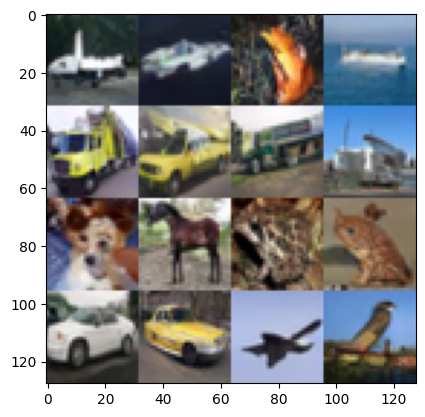

In [17]:
rs_processor = RejectionSamplingProcessor(netD, log_ratio_dict, device, constant_quantile=0.7)

x_t_1 = torch.randn(
    16, args.num_channels, args.image_size, args.image_size
).to(device)


# Start recording memory snapshot history, initialized with a buffer
# capacity of 100,000 memory events, via the `max_entries` field.
torch.cuda.memory._record_memory_history(
    max_entries=100_000
)

try:
    #x_0 = rejection_sample(pos_coeff, netG, rs_processor, n_time=4, x_init=x_t_1, opt=args)
    x_0 = rejection_sample_reinit(pos_coeff, netG, rs_processor, n_time=4, x_init=x_t_1, opt=args)
    grid = tensor_to_grid(x_0)
    plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
    plt.show()
except Exception as exc:
    print(exc)

try:
    torch.cuda.memory._dump_snapshot(f"snapshot.pickle")
except Exception as e:
    print(f"Failed to capture memory snapshot {e}")

# Stop recording memory snapshot history.
torch.cuda.memory._record_memory_history(enabled=None)

In [13]:
from rejection_sampling.utils import q_sample_tp1

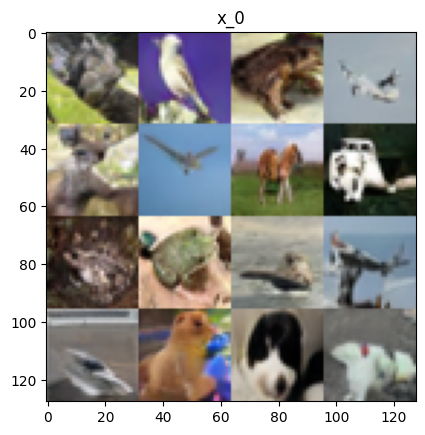

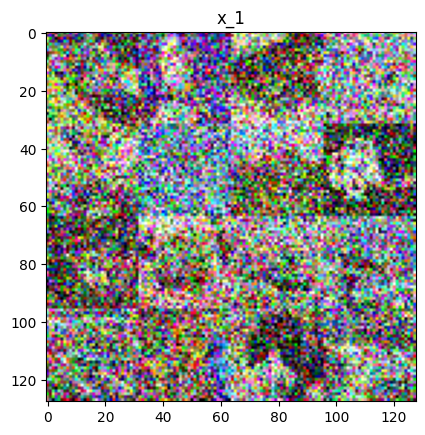

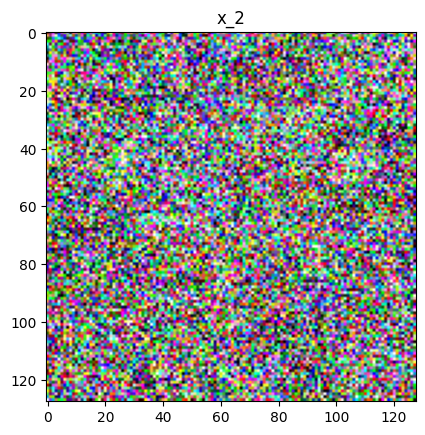

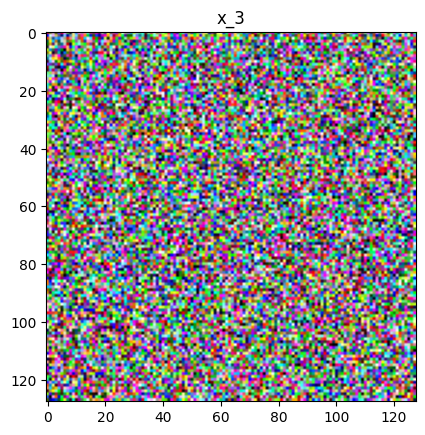

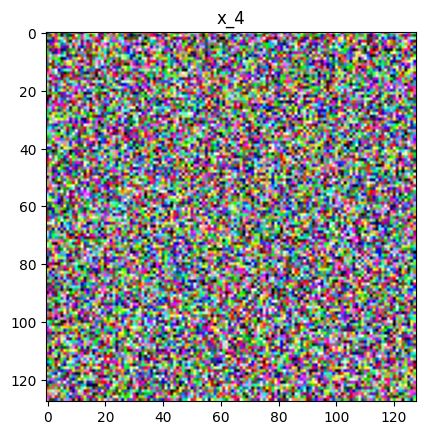

In [14]:
x_t = x_0
grid = tensor_to_grid(x_t)
plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
plt.title("x_0")
plt.show()
for t in range(4):
    x_t = q_sample_tp1(pos_coeff, x_t, t * torch.ones((x_0.shape[0]), dtype=torch.int64, device=x_0.device))
    grid = tensor_to_grid(x_t)
    plt.imshow(grid.permute(1, 2, 0).to("cpu", torch.uint8).numpy())
    plt.title(f"x_{t+1}")
    plt.show()